In [27]:
import pandas as pd
import cv2
import supervision as sv
import numpy as np
import os
import pickle as pl
import torch
import segmentation_models_pytorch as smp
from os.path import expanduser
from scipy.spatial.distance import cdist

In [2]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
trained_models = main_path + "scripts/notebooks/trained_models/"
notebooks_path = main_path + "scripts/notebooks/"

In [3]:
# df_name = "brain_df"
# train_df = pd.read_csv(dataframes_path+"brain_df_train.csv")
# test_df = pd.read_csv(dataframes_path+"brain_df_test.csv")

df_name = "lung_df"
train_df = pd.read_csv(dataframes_path+"lung_df_train.csv")
test_df = pd.read_csv(dataframes_path+"lung_df_test.csv")

# df_name = "lunar_df"
# train_df = pd.read_csv(dataframes_path+"lunar_df_train.csv")
# test_df = pd.read_csv(dataframes_path+"lunar_df_test.csv")

In [4]:
params = {'n_epoch': 35,
          'train_args':{'batch_size': 4, 'num_workers': 1},
          'test_args':{'batch_size': 256, 'num_workers': 1},
          'optimizer_args':{'lr': 5e-3, 'momentum': 0.9},
          'use_sam': True,
          'use_predictor': True,
          'use_generator': False,
          'init_set_size': 100,
          'rounds': 2,
          "activate_sam_at_round":1, 
          "img_size":(128, 128),
          "voting" : True,
          "pre_trained": False,
          "dataset": "Lung_Tumor_Dataset",
          "similarity_check": True}

if params["init_set_size"] == len(train_df):
    params["training_type"] = "no_active"
elif not params["use_sam"]:
    params["training_type"] = "no_sam"
elif params["voting"]:
    params["training_type"] = "voters"
else:
    params["training_type"]="withSAM_NoVoting"

if params["training_type"] == "no_active":
    if params["pre_trained"]:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/pre_trained_Unet_{params["img_size"][0]}.pt'
    else:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/not_pre_trained_Unet_{params["img_size"][0]}.pt'
else:
    params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/{params["training_type"]}/{params["init_set_size"]}'
    
params['test_set_size'] = len(test_df)
params['df'] = df_name
params['query_num'] = int(0.05 * params['init_set_size'])
if params['query_num'] == 0:
    params['query_num'] = 1
params["strategy"] = "MarginSampling"

if params["training_type"] == "voters":
    if params["similarity_check"]:
        params["model_path"] = f'{params["model_path"]}_dbscan'
    params["model_path"] = f'{params["model_path"]}/voters_{params["img_size"][0]}'
        

In [5]:
# voters = [trained_models + f'{params["dataset"]}/voters/{params["init_set_size"]}/voters_{params["img_size"][0]}_{params["rounds"]-1}/model_{i}.pt' for i in range(1,10)]
# main = trained_models + f'{params["dataset"]}/voters/{params["init_set_size"]}/voters_{params["img_size"][0]}_{params["rounds"]-1}/main_Unet.pt'
# voters.append(main)

voters_dbscan = [trained_models + f'{params["dataset"]}/voters/{params["init_set_size"]}_dbscan/voters_{params["img_size"][0]}_{params["rounds"]-1}/model_{i}.pt' for i in range(1,10)]
main_dbscan = trained_models + f'{params["dataset"]}/voters/{params["init_set_size"]}_dbscan/voters_{params["img_size"][0]}_{params["rounds"]-1}/main_Unet.pt'
voters_dbscan.append(main_dbscan)


# main_no_voting = trained_models + f'{params["dataset"]}/withSAM_NoVoting/{params["init_set_size"]}/main_Unet_{params["img_size"][0]}_{params["rounds"]-1}.pt'

In [6]:
params["model_path"]

'/home/jovyan/Active-Learning-Segmentation/scripts/notebooks/trained_models/Lung_Tumor_Dataset/voters/100_dbscan/voters_128'

In [7]:
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"

In [8]:
import sys
sys.path.append('../src')
from strategies import *
sam = SAMOracle(checkpoint_path=sam_path, img_size=params["img_size"])

In [9]:
##Brain tumor
# close results = 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24
# different results = 4, 14, 16, 25, 26, 27

##Lung
# close results = 0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 13, 14, 15, 17
# different results =8
# bad = 7, 12, 16

i=17
import supervision as sv
images = []
gt_masks = []
for i in range(50):
    images.append(np.load(test_df["images"][i], allow_pickle=True))
    gt_masks.append(np.load(test_df["masks"][i], allow_pickle=True))
    # sv.plot_images_grid(
    #     images=[images[i], gt_masks[i]],
    #     grid_size=(1, 2),
    #     titles=['image', 'gt_mask']
    #     )

In [10]:
# test_df_slice = test_df[i:i+1]
test_df_slice = test_df[:50]
def get_data(handler, train_df, test_df):
    return Data(train_df["images"].to_list(), train_df["masks"].to_list(), test_df["images"].to_list(), test_df["masks"].to_list(), handler, img_size=params["img_size"], df=train_df, path= main_path+"/data/processed/", use_sam=params['use_sam'])

from custom_datasets import *

data = get_data(Handler, train_df, test_df_slice)
data.initialize_labels(params["init_set_size"])

In [11]:
trained_models_dir = notebooks_path+"trained_models"    
if params["pre_trained"]:
    model = smp.create_model('Unet', encoder_name='resnet34', in_channels=3, classes = 1)
    first_rd_Unet = torch.load(notebooks_path+f"trained_models/shared_1st_state_pre_trained_{params['init_set_size']}.pt")
else:
    model = UNet(n_channels=3, n_classes=1, bilinear=True)
    first_rd_Unet = torch.load(notebooks_path+f"trained_models/shared_1st_state_not_trained_{params['init_set_size']}.pt")
    
model.load_state_dict(first_rd_Unet)
net = Net(model, params, device = torch.device("cuda"))

In [12]:
def predict(net, model_state:str):
    net.net.load_state_dict(torch.load(model_state))
    net.clf = net.net.to(torch.device("cuda"))
    mask = net.predict(data.get_test_data())[0]
    mask = (mask.squeeze().cpu().sigmoid()> 0.5).float()
    
    return mask

In [13]:
def get_boxes(mask):
    if torch.is_tensor(mask):
        mask = mask.numpy()
        mask = np.array(mask, np.uint8)
    # _, thresh = cv2.threshold(mask, 0.5, 1, 0)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        cnts.append(box)
    return np.array(cnts)   

In [14]:
# tmp = [predict(net, path) for path in voters]
# voters_masks =[]
# for j in range(len(tmp[0])):
#     voters_masks.append([tmp[i][j] for i in range(len(tmp))])


tmp_dbscan = [predict(net, path) for path in voters_dbscan]
voters_dbscan_masks =[]
for j in range(len(tmp_dbscan[0])):
    voters_dbscan_masks.append([tmp_dbscan[i][j] for i in range(len(tmp_dbscan))])

# main_no_voting_mask = predict(net, main_no_voting)

In [15]:
# voters_boxes = [[get_boxes(mask) for mask in masks] for masks in voters_masks]
voters_dbscan_boxes = [[get_boxes(mask) for mask in masks] for masks in voters_dbscan_masks]
# main_no_voting_boxes = [get_boxes(mask) for mask in main_no_voting_mask]

In [16]:
# main_no_voting_sam = [sam.get_mask(img_path=test_df_slice["images"][0], boxes=boxes) for boxes in main_no_voting_boxes]
# print("main_no_voting_sam")

In [17]:
# voters_sam =[[sam.get_mask(img_path=test_df_slice["images"][0], boxes=box) for box in boxes]for boxes in voters_boxes]
# print("voters_sam")
voters_dbscan_sam =[[sam.get_mask(img_path=test_df_slice["images"][0], boxes=box) for box in boxes]for boxes in voters_dbscan_boxes]
print("voters_dbscan_sam")

voters_dbscan_sam


In [18]:
# sums = [sum(masks) for masks in voters_sam]

# majority = [np.array((sum_.squeeze() > 5), dtype=np.float32) for sum_ in sums]

majority_dbscan = [np.array((sum(masks).squeeze() > len(masks)//2), dtype=np.float32) for masks in voters_dbscan_sam]

In [22]:
# for i in range(50):
#     sv.plot_images_grid(
#         images=[images[i], gt_masks[i], majority_dbscan[i], majority[i], main_no_voting_sam[i].squeeze()],
#         grid_size=(1, 5),
#         titles=["image", "gt_mask", "majority_dbscan", "majority", "no_voting"],
#         size=(20,20)
        
#     )

# for i in range(50):
#     sv.plot_images_grid(
#         images=[images[i], gt_masks[i], majority_dbscan[i]],
#         grid_size=(1, 3),
#         titles=["image", "gt_mask", "majority_dbscan"],
#         size=(20,20)
        
#     )

In [21]:
sam_masks = voters_dbscan_sam[4]

In [37]:
def find_contours(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [23]:
def find_centroids(mask):
    contours, _ = find_contours(mask)
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            centroids.append((cX, cY))
    return np.array(centroids)

In [33]:
def calculate_average_proximity(mask1, mask2):
    centroids1 = find_centroids(mask1)
    centroids2 = find_centroids(mask2)
    
    if len(centroids1) == 0 or len(centroids2) == 0:
        return float('inf')  # No centroids found in one of the masks
    
    distances = cdist(centroids1, centroids2, metric='euclidean')
    min_distances = np.min(distances, axis=1)
    average_distance = np.mean(min_distances)

    max_distance = np.sqrt(mask1.shape[0]**2 + mask1.shape[1]**2)
    
    proximity = average_distance / max_distance
    
    return average_distance

In [38]:
average_proximity = calculate_average_proximity(sam_masks[0], sam_masks[1])

print(f"Average Proximity: {average_proximity}")

Average Proximity: 0.022777155839239453


In [39]:
def check_closure(contours):
    closed_contours = 0
    for contour in contours:
        # Approximate the contour to simplify the shape
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # Check if the approximated contour is closed
        if cv2.isContourConvex(approx):
            closed_contours += 1
    return closed_contours

In [40]:
def compare_closure(mask1, mask2):
    contours1 = find_contours(mask1)
    contours2 = find_contours(mask2)
    
    closed_contours1 = check_closure(contours1)
    closed_contours2 = check_closure(contours2)
    
    # Calculate the closure similarity
    total_contours = max(len(contours1), len(contours2))
    if total_contours == 0:
        return 1.0  # No contours in either mask, consider it perfect closure similarity
    
    closure_similarity = abs(closed_contours1 - closed_contours2) / total_contours
    normalized_closure_similarity = 1 - closure_similarity  # Higher value means more similar
    
    return normalized_closure_similarity

In [47]:
closure_similarity = compare_closure(sam_masks[1], sam_masks[6])

print(f"Closure Similarity: {closure_similarity}")

Closure Similarity: 1.0


In [24]:
masks = torch.tensor(np.array(sam_masks))

In [25]:
from dbscan import DBScan, Similarities

sim = Similarities()

Unet Output


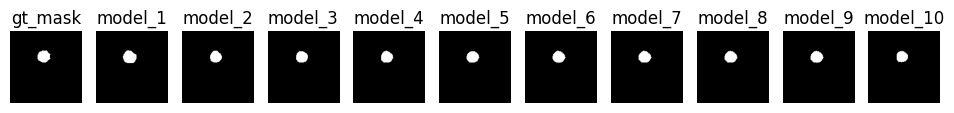

SAM Output


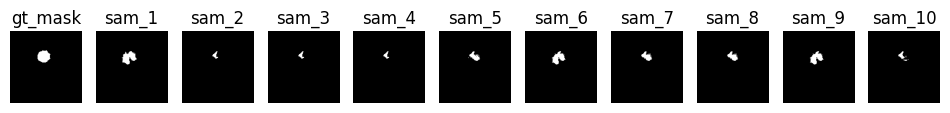

Most similar masks out of SAM Output


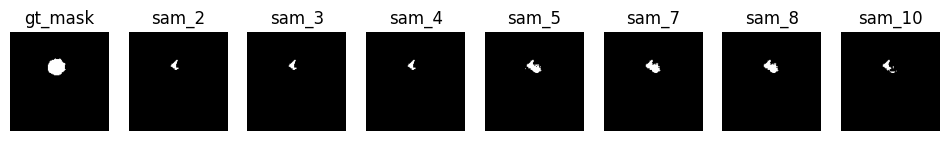

In [34]:
db_scan = DBScan(similarity = sim.iou_score,eps = 0.45, min_samples = 4)

labels = db_scan.fit(masks)
sam_titles = ["sam_"+str(i+1) for i in range(10)]
titles = ["model_"+str(i+1) for i in range(10)]
if len(labels) >= 4:
    print("Unet Output:")
    sv.plot_images_grid(
        images=[gt_masks[4]] + voters_dbscan_masks[4],
        grid_size=(1, len(voters_dbscan_masks[4])+1),
        titles=["gt_mask"] + titles
    )
    print("SAM Output:")
    sv.plot_images_grid(
        images=[gt_masks[4]] + sam_masks,
        grid_size=(1, len(sam_masks)+1),
        titles=["gt_mask"] + sam_titles
    )
    print("Most similar masks out of SAM Output:")
    most_similar_masks = [sam_masks[i] for i in labels]
    most_similar_titles = ["sam_"+str(i+1) for i in labels]
    sv.plot_images_grid(
        images=[gt_masks[4]] + most_similar_masks,
        grid_size=(1, len(most_similar_masks)+1),
        titles=["gt_mask"] + most_similar_titles
    )
else:
    print("not enough similar masks")

In [ ]:
db_scan = DBScan(similarity = sim.cosine_similarity,eps = 0.3, min_samples = 4)

labels = db_scan.fit(masks)
if len(labels) >= 4:
    sv.plot_images_grid(
        images=sam_masks,
        grid_size=(1, len(titles)),
        titles=sam_titles
    )
    most_similar_masks = [sam_masks[i] for i in labels]
    most_similar_titles = ["sam_"+str(i+1) for i in labels]
    sv.plot_images_grid(
        images=most_similar_masks,
        grid_size=(1, len(most_similar_masks)),
        titles=most_similar_titles
    )
else:
    print("not enough similar masks")

In [ ]:
db_scan = DBScan(similarity = sim.eculidian_distance, eps = 0.75, min_samples = 4)

labels = db_scan.fit(masks)
if len(labels) >= 4:
    sv.plot_images_grid(
        images=sam_masks,
        grid_size=(1, len(titles)),
        titles=sam_titles
    )
    most_similar_masks = [sam_masks[i] for i in labels]
    most_similar_titles = ["sam_"+str(i+1) for i in labels]
    sv.plot_images_grid(
        images=most_similar_masks,
        grid_size=(1, len(most_similar_masks)),
        titles=most_similar_titles
    )
else:
    print("not enough similar masks")

In [ ]:
n_samples = len(sam_masks)
similar = []

for i in range(n_samples):
    for j in range(i+1, n_samples):
        iou_score = sim.iou_score(sam_masks[i], sam_masks[j])
        if iou_score >=0.60:
            similar.append(i)
            similar.append(j)
labels = set(similar)
if len(labels) >= 4:
    sv.plot_images_grid(
        images=sam_masks,
        grid_size=(1, len(titles)),
        titles=sam_titles
    )
    most_similar_masks = [sam_masks[i] for i in labels]
    most_similar_titles = ["sam_"+str(i+1) for i in labels]
    sv.plot_images_grid(
        images=most_similar_masks,
        grid_size=(1, len(most_similar_masks)),
        titles=most_similar_titles
    )
else:
    print("not enough similar masks")

In [ ]:
# paths=[]
# for dirname, _, filenames in os.walk(main_path +"data/processed/Brain_MRI_segmentation/oracle/"):

#     for filename in filenames:
#         paths.append(os.path.join(dirname, filename))

# idx=[]
# for i, path in enumerate(train_df["oracle"]):
#     if path in paths:
#         idx.append(i)

# print(len(paths), len(idx))

# imgs=[]
# gt_masks = []
# paths=[]
# oracles = []
# for i in idx:
#     imgs.append(cv2.imread(train_df["images"][i]))
#     gt_masks.append(cv2.resize(cv2.cvtColor(cv2.imread(train_df["masks"][i]), cv2.COLOR_BGR2GRAY), (128,128), interpolation=cv2.INTER_CUBIC))       
#     oracles.append(np.load(train_df["oracle"][i], allow_pickle=True))
#     paths.append(train_df["oracle"][i])

# for i in range(len(oracles)):
#     if oracles[i].shape!= (128, 128):
#         print(i, oracles[i].shape)

In [ ]:
# gtmasks= torch.tensor(np.array(gt_masks)).unsqueeze_(1)
# preds = torch.tensor(np.array(oracles)).unsqueeze_(1)

# tp, fp, fn, tn = smp.metrics.get_stats(preds.long(), gtmasks.long(), mode="binary", threshold=0.5)

# # Calculate IoU and F1-score
# iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
# accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
# f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
# recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
# precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

# print(f"Oracles to GT: iou_score = {iou:.2f}, accuracy = {accuracy:.2f}, precision = {precision:.2f}, recall = {recall:.2f}, f1_score = {f1:.2f}")

In [ ]:
# i=0
# for img, gt_mask, oracle in zip(imgs[i:i+50], gt_masks[i:i+50], oracles[i:i+50]):
#     sv.plot_images_grid(
#         images=[img, gt_mask, oracle],
#         grid_size=(1, 3),
#         titles =["image", "gt_mask", "oracle"]
#     )

In [ ]:
# def load_masks(paths, voting_dir):
#     masks=[]
#     for path in paths:
#         path = path.split("/")
#         path[-2] = voting_dir
#         path = "/".join(path)
#         if os.path.isfile(path):
#             # mask = np.load(path, allow_pickle=True)
            
#             # if len(mask.shape) == 3:
#             #     mask = mask[0]
        
#             # masks.append(mask)
#             masks.append(path)
#     return masks

In [ ]:
# def plotRoundMasks(round, df):
#     oracle_mv_128_paths = []
#     for dirname, _, filenames in os.walk(main_path +f"data/processed/oracle_mv_128_{round}/"):

#         for filename in filenames:
#             oracle_mv_128_paths.append(os.path.join(dirname, filename))
            
#     oracle_mv_128_paths = load_masks(oracle_mv_128_paths, "oracle")

#     idx=[]
#     for i, path in enumerate(df["oracle"]):
#         if path in oracle_mv_128_paths:
#             idx.append(i)
            
#     imgs=[]
#     gt_masks = []
#     paths=[]
#     oracles = []
#     for i in idx:
#         imgs.append(cv2.imread(df["images"][i]))
#         gt_masks.append(cv2.resize(cv2.cvtColor(cv2.imread(df["masks"][i]), cv2.COLOR_BGR2GRAY), (128,128), interpolation=cv2.INTER_CUBIC))       
#         oracles.append(np.load(df["oracle"][i], allow_pickle=True))
        
#     for img, gt_mask, oracle in zip(imgs, gt_masks, oracles):
#         sv.plot_images_grid(
#             images=[img, gt_mask, oracle],
#             grid_size=(1, 3),
#             titles =["image", "gt_mask", "oracle"]
#         )



In [ ]:
# plotRoundMasks(1 , train_df,)

In [ ]:
# oracle_mv_128_1 = load_masks(paths, "oracle_mv_128_1")
# oracle_mv_128_2 = load_masks(paths, "oracle_mv_128_2")
# oracle_mv_128_3 = load_masks(paths, "oracle_mv_128_2")
# oracle_mv_128_4 = load_masks(paths, "oracle_mv_128_4")

In [ ]:
# print("Images")
# sv.plot_images_grid(
#     images=imgs,
#     grid_size=(1, len(imgs)),
# )

# print("Gt_Masks")
# sv.plot_images_grid(
#     images=gt_masks,
#     grid_size=(1, len(gt_masks)),
# )

# print("Oracles")
# sv.plot_images_grid(
#     images=oracles,
#     grid_size=(1, len(oracles)),
# )

In [ ]:

# i = idx[98]
# img = cv2.imread(train_df["images"][i])
# gt_mask = cv2.imread(train_df["masks"][i])
# oracle = np.load(train_df["oracle"][i], allow_pickle=True)

# sv.plot_images_grid(
#     images=[img, gt_mask, oracle],
#     grid_size=(1, 3)
# )

# train_df["oracle"][i]

In [ ]:
# def checkOutput(all_idx, bad_idx):
#     for i in bad_idx:
#         img = cv2.imread(train_df["images"][i])
#         gt_mask = cv2.imread(train_df["masks"][i])
#         if os.path.isfile(train_df["oracle"][i]):
#             oracle = np.load(train_df["oracle"][i], allow_pickle=True)
#             sv.plot_images_grid(
#                 images=[img, gt_mask, oracle],
#                 grid_size=(1, 3)
#             )
#             x = input("Do you want to delete?")
#             if x =='n':
#                 continue
#             else:
#                 os.remove(train_df["oracle"][i])
        

In [ ]:
# # bad_idx = [202, 205, 212, 213, 216, 219]
# i = 0
# checkOutput(idx, idx[i:i+100])

In [ ]:
# def plotComparison(imgs, mv_masks, no_mv_masks, wmv_masks, gt_masks):
#     print("Images")
#     sv.plot_images_grid(
#         images=imgs,
#         grid_size=(1, len(imgs)),
#     )

#     print("Masks with Majority Voting")
#     sv.plot_images_grid(
#         images=mv_masks,
#         grid_size=(1, len(mv_masks)),
#     )

#     print("Masks without Majority Voting")
#     sv.plot_images_grid(
#         images=no_mv_masks,
#         grid_size=(1, len(no_mv_masks)),
#     )

#     print("Masks wit Weighted Majority Voting")
#     sv.plot_images_grid(
#         images=wmv_masks,
#         grid_size=(1, len(wmv_masks)),
#     )


#     print("GT_Masks")
#     sv.plot_images_grid(
#         images=gt_masks,
#         grid_size=(1, len(imgs)),
#     )

In [ ]:
# plotComparison(imgs, oracle_mv_128_1, oracle_mv_128_2, oracle_mv_128_3, gt_masks)

In [ ]:
# round_2_idx = [1406, 2442,  533,  536, 1425]

# imgs_2=[]
# gt_masks_2 = []
# paths=[]
# for i in round_2_idx:
#     # print(train_df["images"][i])
#     imgs_2.append(cv2.imread(train_df["images"][i]))
#     gt_masks_2.append(cv2.imread(train_df["masks"][i]))
#     paths.append(train_df["oracle"][i])

In [ ]:
# mv_masks_128 = load_masks(paths, "oracle_mv_128")
# no_mv_masks_128 = load_masks(paths, "oracle_no_mv_128")
# wmv_masks_128 = load_masks(paths, "oracle_wmv_128")

In [ ]:
# plotComparison(imgs_2, mv_masks_128, no_mv_masks_128, wmv_masks_128, gt_masks_2)

In [ ]:
# round_3_idx = [1646, 1679, 1674, 1668, 1662]

# imgs_3=[]
# gt_masks_3 = []
# paths=[]
# for i in round_3_idx:
#     # print(train_df["images"][i])
#     imgs_3.append(cv2.imread(train_df["images"][i]))
#     gt_masks_3.append(cv2.imread(train_df["masks"][i]))
#     paths.append(train_df["oracle"][i])

In [ ]:
# mv_masks_128_3 = load_masks(paths, "oracle_mv_128_3")
# no_mv_masks_128_3 = load_masks(paths, "oracle_no_mv_128_3")
# wmv_masks_128_3 = load_masks(paths, "oracle_wmv_128_3")

In [ ]:
# plotComparison(imgs_3, mv_masks_128_3, no_mv_masks_128_3, wmv_masks_128_3, gt_masks_3)